In [1]:
import numpy as np
import cmath
from scipy import signal
from scipy.io import wavfile
import matplotlib
import matplotlib.pyplot as plt
import math
import warnings; warnings.simplefilter('ignore') # Para quitar mensajes de warning
import upv_audio 
matplotlib.rcParams['figure.figsize'] = (10, 5)

# Introducción al análisis espectral

El objetivo de este primer cuaderno es introducir el fundamento de cómo dada una señal (fragmento de) es posible averiguar su espectro.

El proceso consiste en:

1. Suponiendo conocida las frecuencias determinar la amplitud y la fase.

2. Normalmente la frecuencia no es conocida. Para ello :
  
  * repetiremos el paso anterior "barriendo" en frecuencia.
  
  * En aquellas frecuencias en las que no existía sinusoide simplemente obtendremos amplitud nula.
  
Inicialmente supondremos que la señal es muuuy larga.

Luego veremos qué sucede cuando es de duración limitada (caso habitual)

___________________



## Generación de suma de sinusoides

Supondremos una señal 

* compuesta por la suma de 3 tonos, de distintas amplitudes frecuencias y fases.

* La duración la tomaremos muuy larga

* La frecuencia de muestreo supondremos que es suficientemente alta como para no tener aliasing.

In [2]:
# Datos
A1=0.5 
f1=300.0 # hz
phi1= 0.0

A2=0.2
f2=96.0 # hz
phi2= np.pi/3 # radianes

A3=0.35 
f3=503.0 # hz
phi3= -np.pi # radianes

fs=16000.0

dur=1#sg

In [3]:
nmues = int(fs*dur)
n=np.arange(nmues)
Ts=1.0/fs
nTs = n*Ts
s1=A1*np.cos( 2*np.pi * f1 *nTs + phi1)
s2=A2*np.cos( 2*np.pi * f2 *nTs + phi2)
s3=A3*np.cos( 2*np.pi * f3 *nTs + phi3)

s= s1+s2+s3

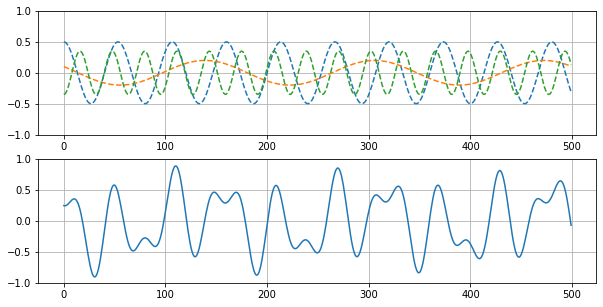

In [4]:
_=plt.subplot(2,1,1)
_=plt.plot(s1[:500],linestyle='dashed')
_=plt.plot(s2[:500],linestyle='dashed')
_=plt.plot(s3[:500],linestyle='dashed')
_=plt.ylim([-1,1])
_=plt.grid()
_=plt.subplot(2,1,2)
_=plt.plot(s[:500],linestyle='solid')
_=plt.ylim([-1,1])
_=plt.grid()

### Sumas de fasores

Cada sinusoide {$A_k, f_k,\, \phi_k$} se puede poner como suma de dos fasores:

* $A_k/2,\, f_k,\,  \phi _k$
* $A_k/2,\, -f_k,\, -\phi_k$

Lo que haremos será **determinar los parámetros de los fasores** en vez de los de la sinusoide.

$$ x(t) = \frac{A_1}{2} e^{j\omega _1 t + \phi_1} +  \frac{A_1}{2}  e^{-j\omega _1 t - \phi_1} + 
\frac{A_2}{2} e^{j\omega _2 t + \phi_2} +  \frac{A_2}{2}  e^{-j\omega _2 t - \phi_2} +
\frac{A_3}{2} e^{j\omega _3 t + \phi_3} +  \frac{A_3}{2}  e^{-j\omega _3 t - \phi_3} $$


## Estima de parámetros espectrales conocida la frecuencia

Para determinar la amplitud del fasor de frecuencia $f_1$ lo que haremos es calcular medio de la señal $x(t)$ por 
$e^{-j\omega _1 t}$:

$$ x(t)\, e^{-j\omega _1 t} = \frac{A_1}{2} e^{ \phi_1} +  \frac{A_1}{2}  e^{-j\omega _1 t -j\omega _1 t  - \phi_1} + 
\frac{A_2}{2} e^{j\omega _2 t -j\omega _1 t + \phi_2} +  \frac{A_2}{2}  e^{-j\omega _2 t -j\omega _1 t - \phi_2} +
\frac{A_3}{2} e^{j\omega _3 t -j\omega _1 t + \phi_3} +  \frac{A_3}{2}  e^{-j\omega _3 t -j\omega _1 t - \phi_3} $$

Cuyo valor medio vale

$$ \left< x(t)\, e^{-j\omega _1 t} \right> = \frac{A_1}{2} e^{ \phi_1} $$


A continuación aplicaremos esta idea para ver qué se obtiene.

Estamos suponiendo que las frecuencias de momento son conocidas.

In [5]:
# Empezaremos por f1
f=f1/fs
fasor = np.exp(-1j*2.0*np.pi*f*n)
A1est = np.mean(fasor * s)
print(cmath.polar(A1est))



(0.2499999999999999, 5.254241486341018e-15)


Observemos que:

* Partiendo de la señal sumada "s"

* Suponiendo conocida la frecuencia de la componente , hemos determinado su amplitud (la mitad de) y su fase.

Repitamos con las otras dos frecuencias

In [6]:
f=f2/fs
fasor = np.exp(-1j*2.0*np.pi*f*n)
A2est = np.mean(fasor * s)
print(cmath.polar(A2est),np.pi/3)

(0.10000000000000005, 1.0471975511965974) 1.0471975511965976


In [7]:
f=f3/fs
fasor = np.exp(-1j*2.0*np.pi*f*n)
A3est = np.mean(fasor * s)
print(cmath.polar(A3est),np.pi)

(0.17499999999999982, 3.1415926535897416) 3.141592653589793


In [8]:
# Veamos que pasa si pongo una frecuencia que no sea de las que forman parte de la señal
f=1400/fs
fasor = np.exp(-1j*2.0*np.pi*f*n)
A4est = np.mean(fasor * s)
print(cmath.polar(A4est))

(3.548456888682079e-16, -2.9822723864463008)


**Observaciones**

Vemos que el valor obtenido es prácticamente 0

## Barrido en frecuencia

En la práctica, uno solo tiene *s*

Las frecuencias del cocktail se desconocen.

Lo que se hace es un barrido en frecuencia

In [11]:
fa =np.arange(0,600)
frecs=[]
Ampls=[]
for f in fa:
    fasor = np.exp(-1j*2.0*np.pi*f/fs*n)
    Aest = np.mean(fasor * s)
    frecs.append(f)
    Ampls.append(Aest)

frecs=np.array(frecs)
Ampls=np.array(Ampls)



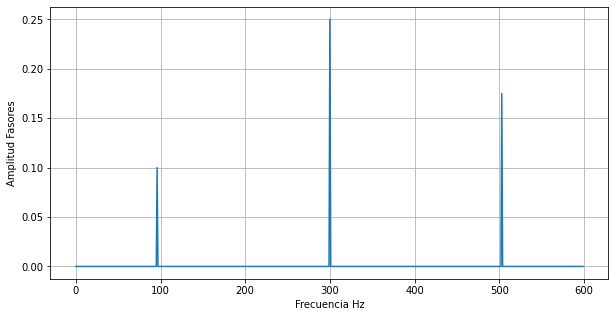

In [14]:
_=plt.plot(frecs,np.abs(Ampls))
_=plt.grid()
_=plt.xlabel('Frecuencia Hz')
_=plt.ylabel('Amplitud Fasores')

### Observaciones

* Vemos que barriendo en frecuencia podemos obtener el espectro.

* El espectro son números complejos

  * El módulo es la amplitud
  
  * El argumento es la fase

* Para cada frecuencia tengo que hacer la media de la señal por un fasor.

* Las frecuencias a ensayar se suelen tomar equiespaciadas

## DFT/FFT

* Calcular la media es lo mismo que calcular la suma y luego dividir por el número de valores

* La suma anterior, cuando las frecuencias están equiespaciadas se puede calcular mediante DFT

 $$ X[k] = \sum _ {n=0} ^{L-1} x[n] \, \exp (- 2 j \pi \frac{k }{L} n)$$
 
* Operación que dadas L muestras devuelve las amplitudes (complejas) de L fasores de frecuencias equiespaciadas $f_k= k/L$

* Las amplitudes de las sinusoides se obtienen mediante $A[k]= 2/L X[k]$
  * El 2 es para pasar de fasor a sinusoide
  
  * el 1/L es para calcular media en vez de suma
  
* la DFT:
   * está implementada en numpy
   * Existe método cálculo rápido *FFT*. Especialmente eficiente si $L=2^\nu$ con $\nu$ entero.
* Relleno por ceros. Es posible reducir el espaciado en frecuencia, extentiendo la señal con ceros

In [19]:
def espectroFFT(x, NFFT=None):
    
    # Si no damos NFFT es directamente la longitud de la señal
    L=len(x)
    if NFFT==None:
        NFFT = L 
       
    # Comprobamos que NFFT sea mayor que la longitud de x.
    assert L<=NFFT, 'NFFT tiene que ser mayor o igual a que len(x)'

    # Calculamos la FFT. Se rellena con ceros desde L a NFFT 
    X = np.fft.fft(x,NFFT)
   
    A=2/L*np.abs(X)
   
    # Generamos el eje de frecuencia digital
    fd = np.arange(0, NFFT)/NFFT
    
  # Nos quedamos con la primera mitad (hasta frec 0.5)
    A=A[0:NFFT//2]
    fd=fd[0:NFFT//2]
    
    return A,fd 

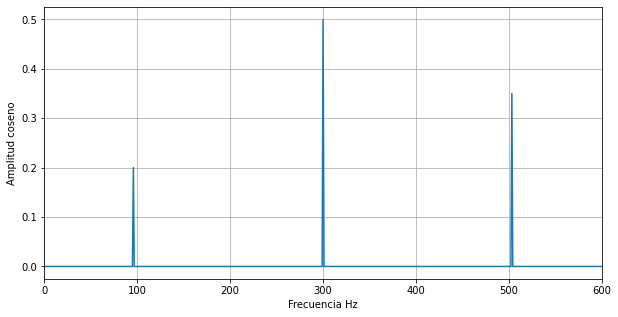

In [22]:
A,fd=espectroFFT(s)
_=plt.plot(fd*fs,A)
_=plt.xlim(0,600)
_=plt.grid()
_=plt.xlabel('Frecuencia Hz')
_=plt.ylabel('Amplitud coseno')
